# How betweeness is correlated with energies of nodes?

In this experiment we are considering the measure of energy dispersion and its correlation to betweeness structural measure of nodes. There are multiple graph energies proposed in the literature, but our primary interest lies in Randić energy.

Within the experiment we calculate Randić energy fo each node by means of Randić energy of their ego-network. Then we compare how betweenes of nodes are correlated with their Randić energy.


### Randić energy

Randić matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_R(i,j)=
\begin{cases}
0 & \mathit{if} & i=j\\
\frac{1}{\sqrt{d_i d_j}} & \mathit{if} & (i,j) \in E\\
0 & \mathit{if} & (i,j) \notin E
\end{cases}
$$

Randić energy of a graph is defined as $E_R(G) = \sum\limits_{i=1}^n |\rho_i|$, where $\rho_1, \ldots, \rho_n$ are the eigenvalues of the Randić matrix $M_R$.

In [4]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [328]:
from tqdm import tqdm
from ggplot import *

import pandas as pd
import numpy as np
import networkx as nx
import scipy, scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

from networkentropy import network_energy as ne

In [42]:
def calculate_betweenes(graph):
    return nx.betweenness_centrality(graph)

def calculate_randic_energy(graph):
    results={}
    for n in graph.nodes:
        g = nx.ego_graph(G=graph, n=n, radius=1)
        results[n]=ne.get_randic_energy(g)
    return results

### Frist experiment: synthetic data

In [330]:
results=pd.DataFrame(columns=['betweeness', 'randic', 'network', 'param'])

for p in tqdm(range(1,100)):

    generators = {
        'random': nx.erdos_renyi_graph(n=num_nodes, p=p/100.0),
        'smallworld': nx.watts_strogatz_graph(n=num_nodes, k=4, p=p/100.0),
        'waxman': nx.waxman_graph(n=num_nodes, alpha=p/100.0, beta=0.1),
        'powerlaw': nx.powerlaw_cluster_graph(n=num_nodes, m=3, p=p/1000.0)
    }
    
    for generator in generators.keys():
        
        G = generators[generator]

        bet=calculate_betweenes(G)
        re=calculate_randic_energy(G)
        betre = {key:[bet[key], re[key]] for key in bet}

        betredf=pd.DataFrame({'betweeness':[i[0] for i in betre.values()], 'randic':[i[1] for i in betre.values()]})
        betredf['network']=generator
        betredf['param']=p
        results=pd.concat([results,betredf])
        

100%|██████████| 99/99 [05:31<00:00,  3.35s/it]


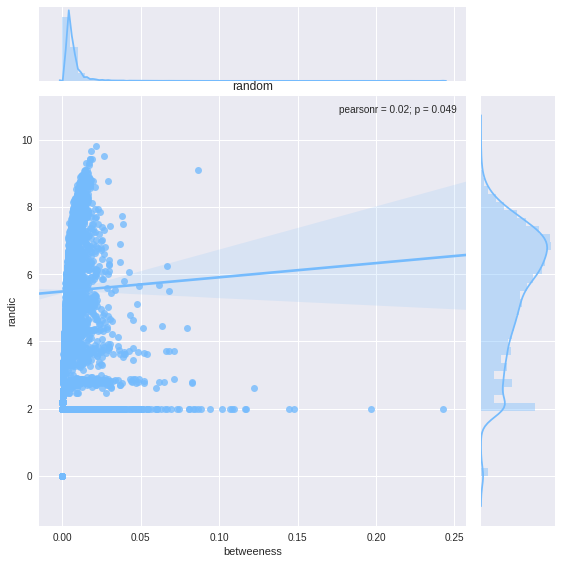

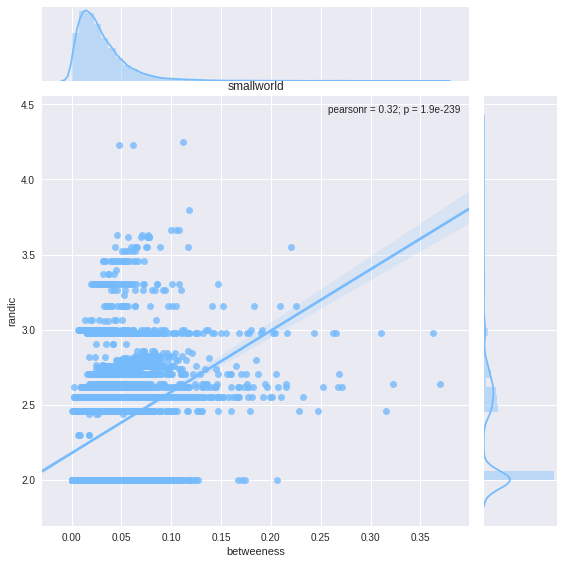

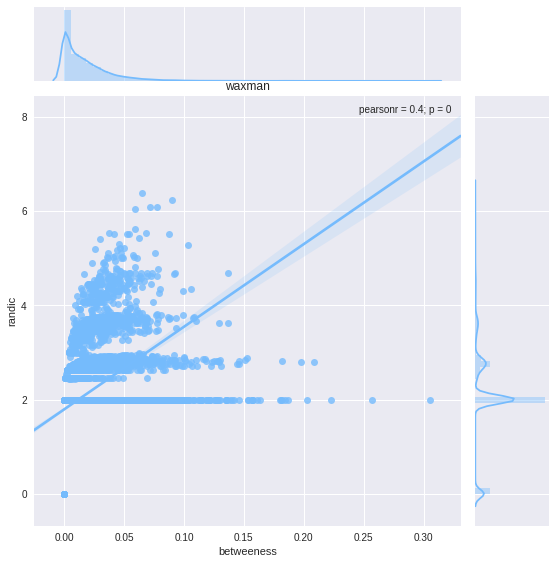

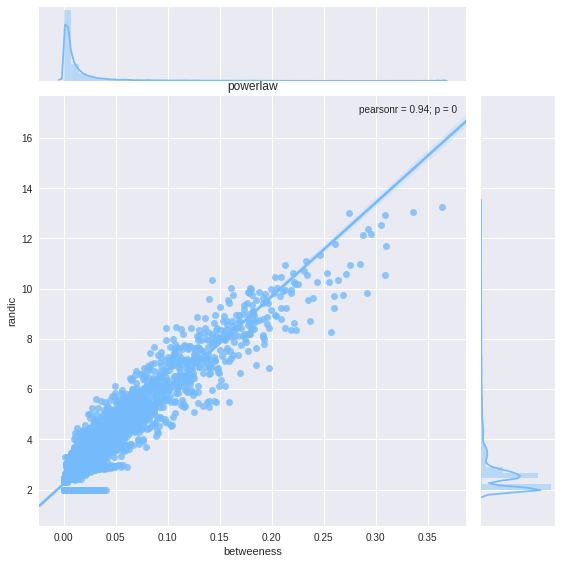

In [329]:
for network in results.network.unique():
    sns.jointplot("betweeness", "randic", data=results[results['network']==network], kind="reg", color="xkcd:sky blue", size=8)
    sns.plt.title(network)


#### Summary: 
- only in power law networks we can observe high correlations ($\rho=0.94$) between Randić energy of ego networks and betweeness

### Second experiment: real-word data (23 examplary networks from Moreno)

In [322]:
from bs4 import BeautifulSoup
import requests
import wget
import tarfile
import os
import shutil
import time

In [292]:
def read_avalilable_datasets_konect():
    base_url = "http://konect.uni-koblenz.de/downloads/"
#     print(base_url)
    response = requests.get(base_url)
    
    if response.status_code != 200:
        print("An error occurred while getting data.")
    else:
        html = response.content
        soup = BeautifulSoup(html, "html5lib")
        
        table_html = soup.find(id='sort1')
        
        thead_html = table_html.find('thead')
        tbody_html = table_html.find('tbody')
         
        column_names=[row.text for row in thead_html.findAll('td')]
        rows = tbody_html.findAll('tr')
        values=[[cell.get('href') for cell in value('a') if 'tsv' in cell.get('href')] for value in rows]
        return [val[0].replace('.tar.bz2','').replace('tsv/','') for val in values]
        
def download_tsv_dataset_konect(network_name):
    assert (network_name in read_avalilable_datasets_konect()),"No network named: '"+network_name+"' found in Konect!"
    
    tsv_file = 'http://konect.uni-koblenz.de/downloads/tsv/'+network_name+'.tar.bz2'
    output_file=network_name+'.tar.bz2'
    file_name = wget.download(tsv_file, out=output_file)
    if os.path.exists(output_file):
        shutil.move(file_name,output_file)
    
    return output_file
    
def unpack_tar_bz2_file(file_name):
    tar = tarfile.open("./"+file_name, "r:bz2")
    output_dir="./network_"+file_name.replace('.tar.bz2','')+"/"
    tar.extractall(output_dir)
    tar.close()
    return output_dir

def build_network_from_out_konect(network_name):
    file_name=download_tsv_dataset_konect(network_name=network_name)
    output_dir=unpack_tar_bz2_file(file_name)+network_name+"/"
    files = [file for file in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, file))]
    out_file = [file for file in files if 'out.' in file]
    assert (len(out_file)>0), 'No out. file in the directory.'
    
    #building network
    G=nx.read_adjlist(output_dir+out_file[0], comments='%')
    
    return G

In [308]:
networks_names=['moreno_beach',
 'moreno_bison',
 'moreno_blogs',
 'moreno_cattle',
 'moreno_crime',
 'moreno_health',
 'moreno_hens',
 'moreno_highschool',
 'moreno_innovation',
 'moreno_kangaroo',
 'moreno_lesmis',
 'moreno_mac',
 'moreno_names',
 'moreno_oz',
 'moreno_propro',
 'moreno_rhesus',
 'moreno_sampson',
 'moreno_seventh',
 'moreno_sheep',
 'moreno_taro',
 'moreno_train',
 'moreno_vdb',
 'moreno_zebra']

In [309]:
networks=[]
for network_name in tqdm(networks_names):
    networks.append(build_network_from_out_konect(network_name))


 30%|███       | 7/23 [00:06<00:15,  1.07it/s]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 23/23 [00:22<00:00,  1.01it/s]


In [324]:
results_networks=pd.DataFrame(columns=['betweeness', 'randic', 'network', 'param', 'time_randic','time_betweeness'])

for i in tqdm(range(len(networks))):
    network=networks[i]
    start = time.clock()
    bet=calculate_betweenes(network)
    bet_time=time.clock() - start
    start = time.clock()
    re=calculate_randic_energy(network)
    re_time=time.clock() - start
    betre = {key:[bet[key], re[key]] for key in bet}

    betredf=pd.DataFrame({'betweeness':[i[0] for i in betre.values()], 'randic':[i[1] for i in betre.values()]})
    betredf['network']=networks_names[i]
    betredf['param']=None
    betredf['time_randic']=re_time
    betredf['time_betweeness']=bet_time
    results_networks=pd.concat([results_networks,betredf])

100%|██████████| 23/23 [03:44<00:00,  9.76s/it]


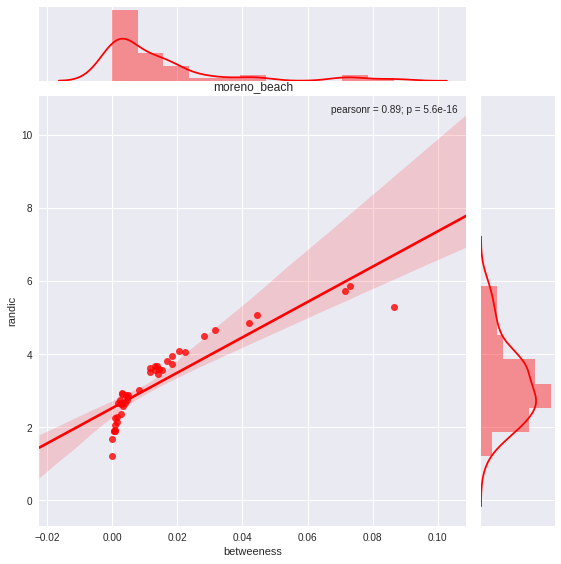

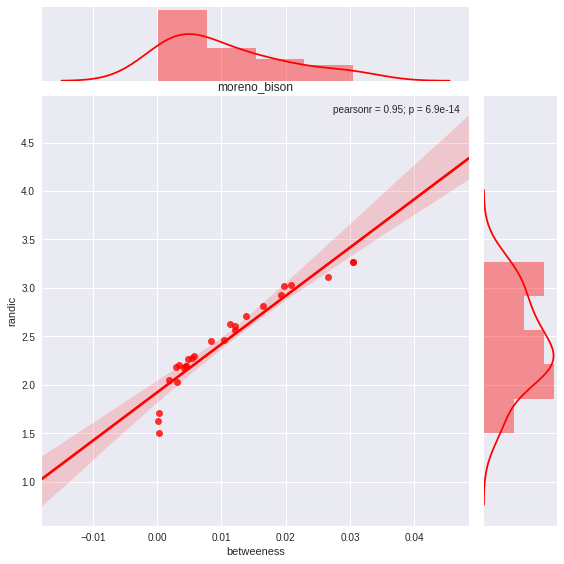

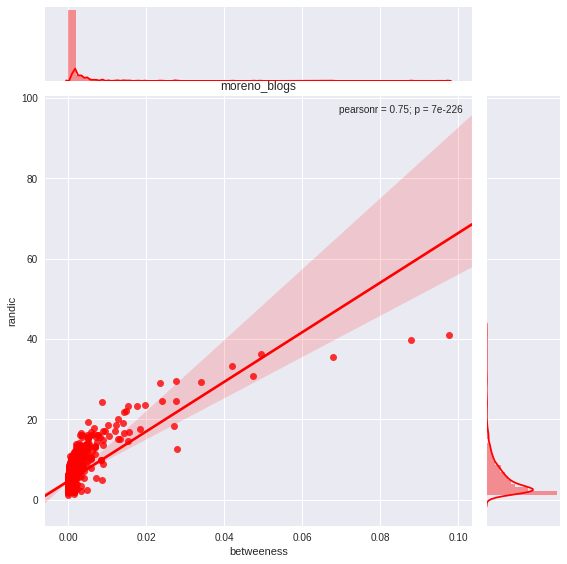

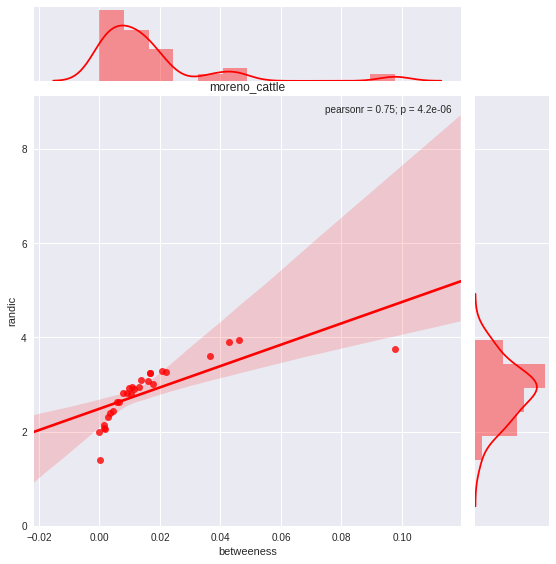

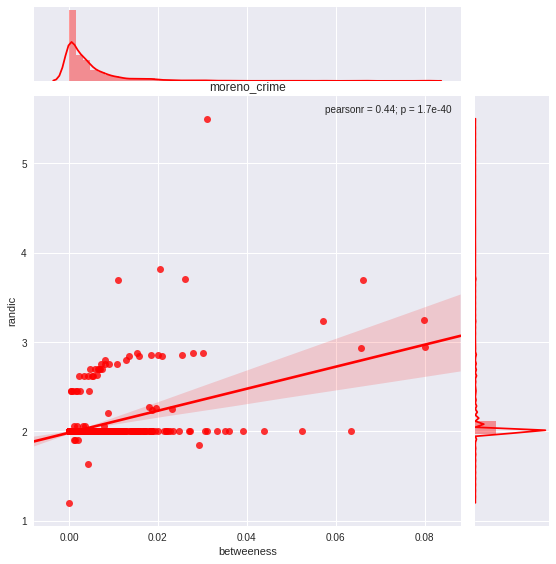

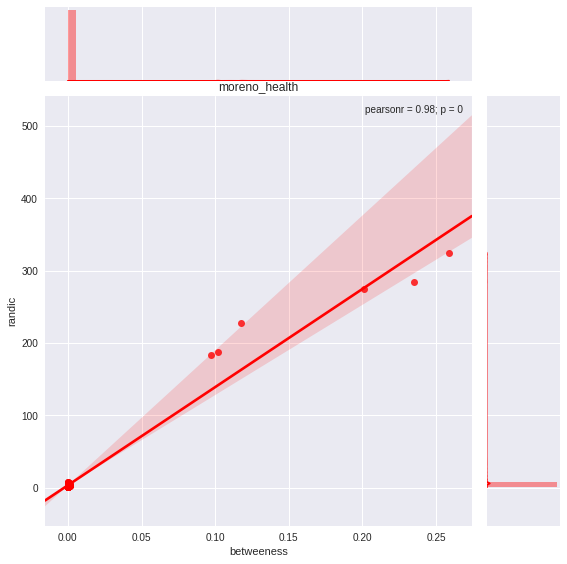

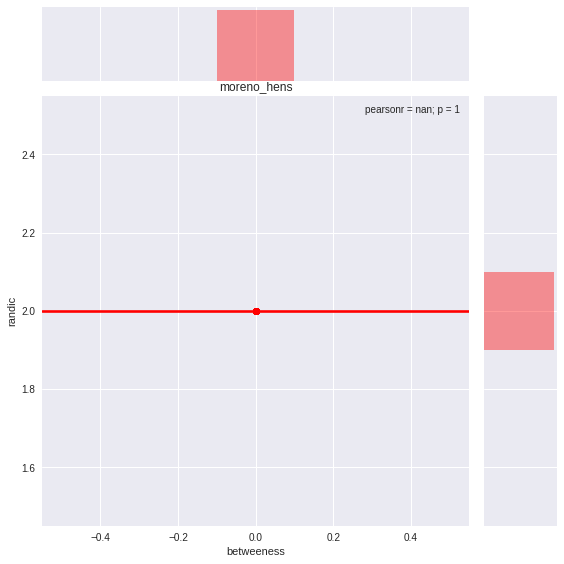

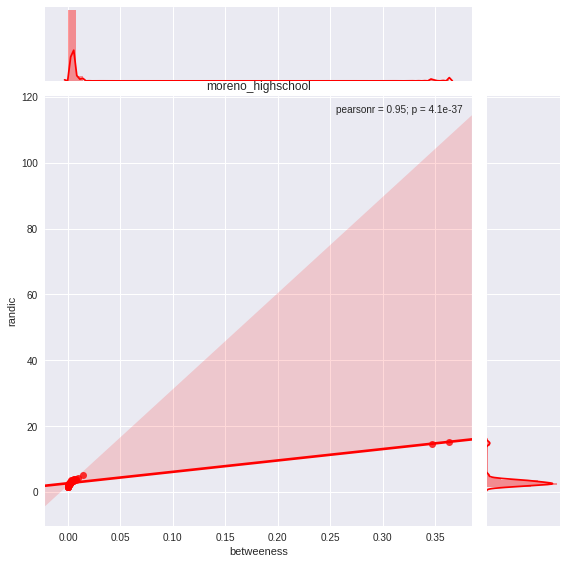

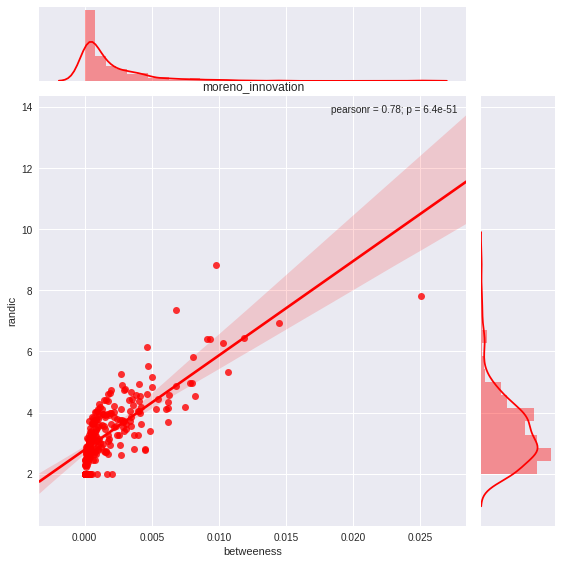

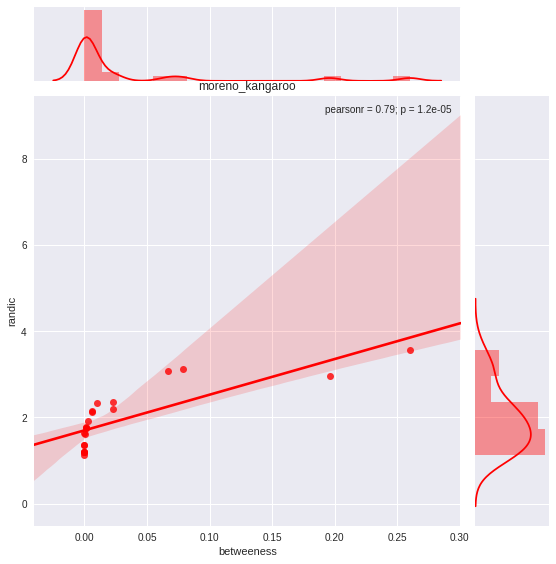

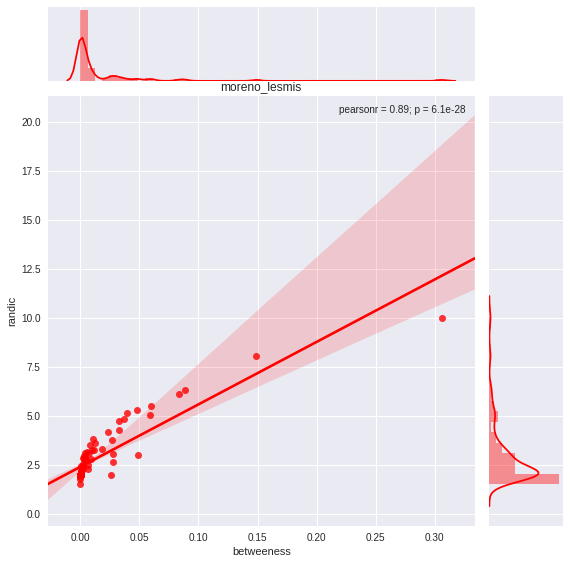

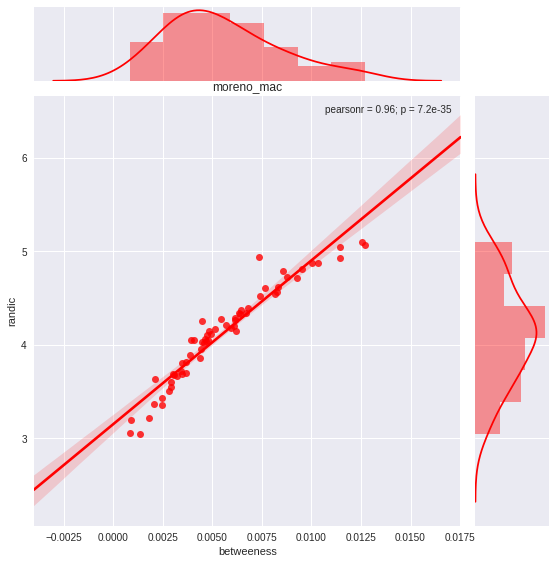

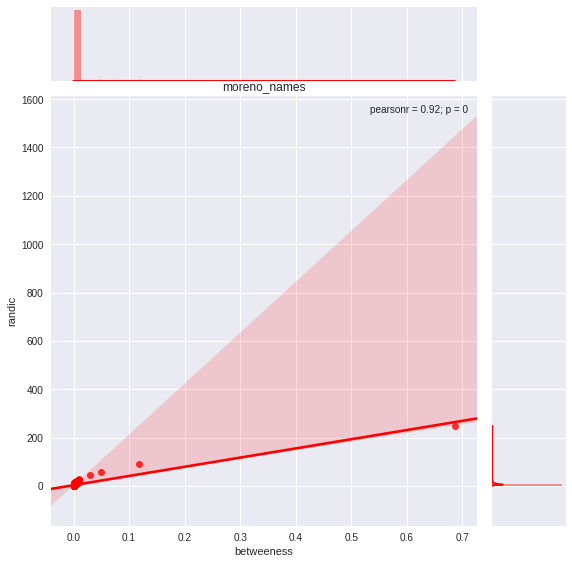

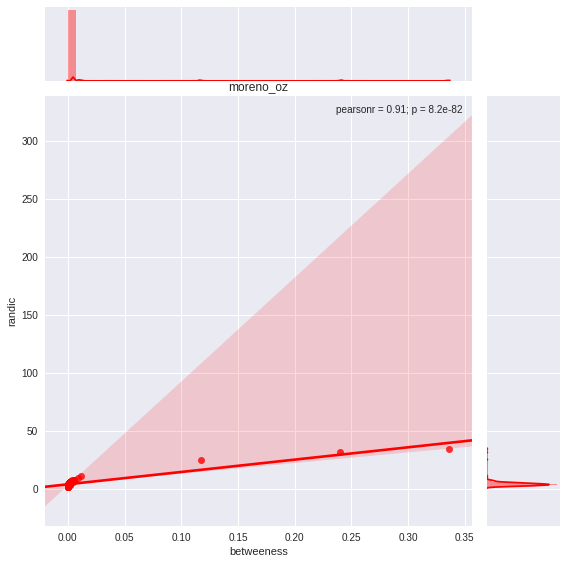

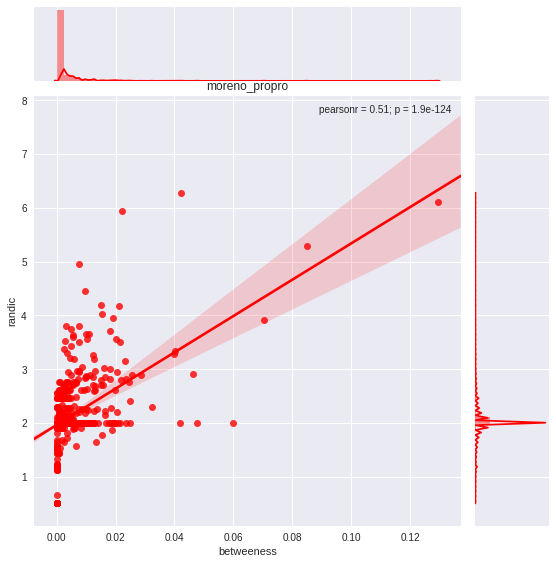

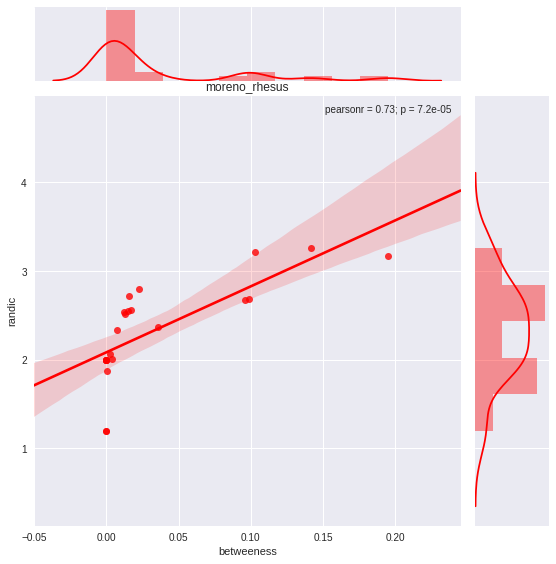

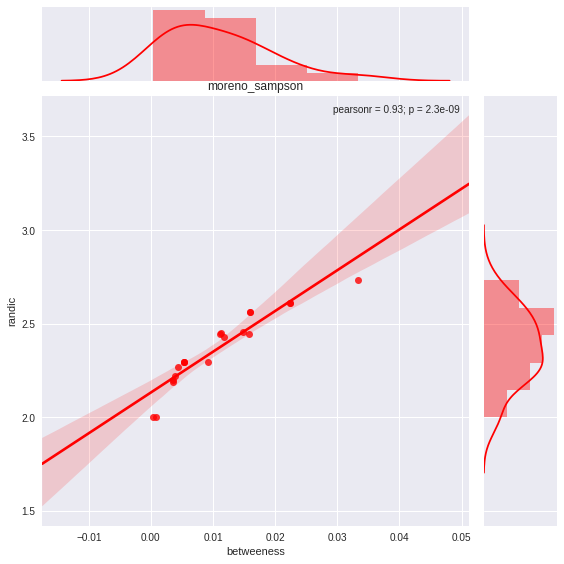

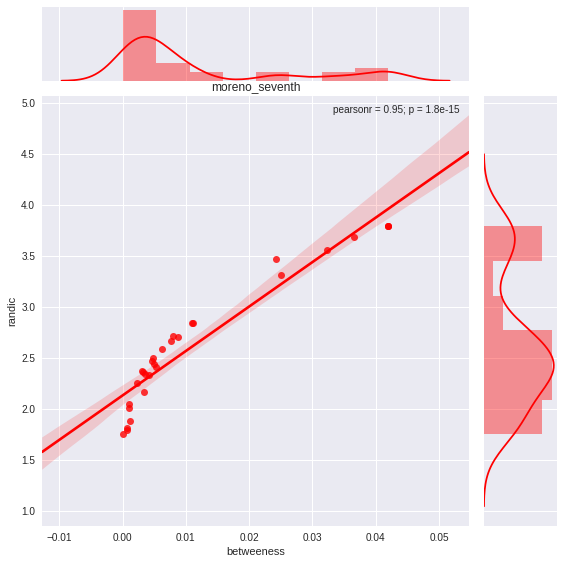

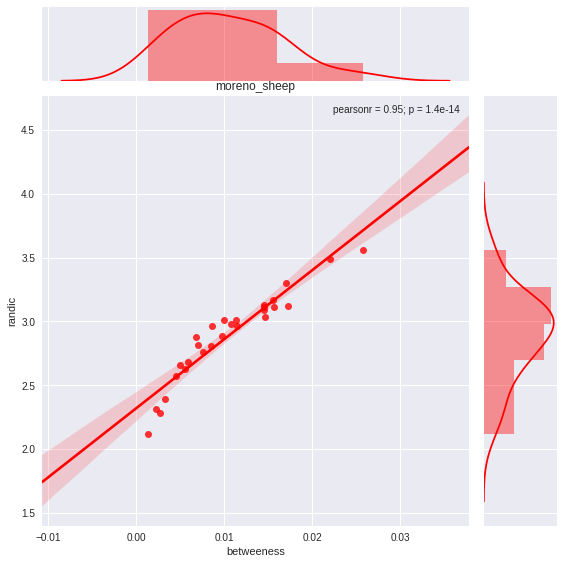

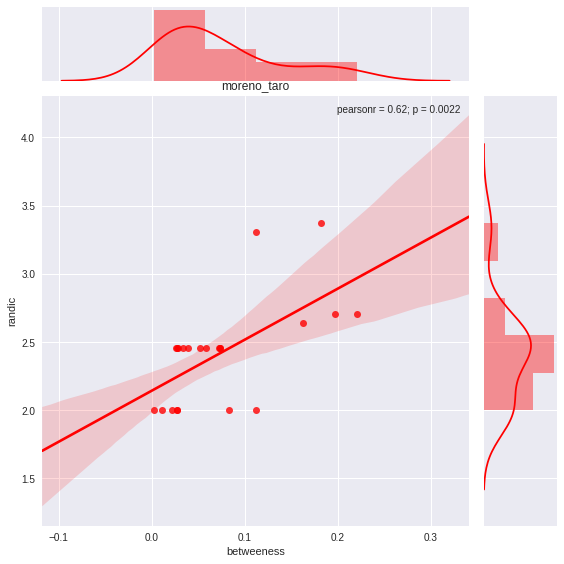

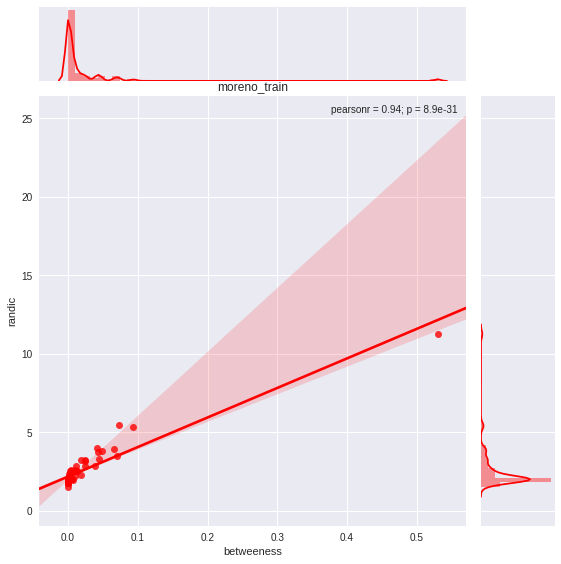

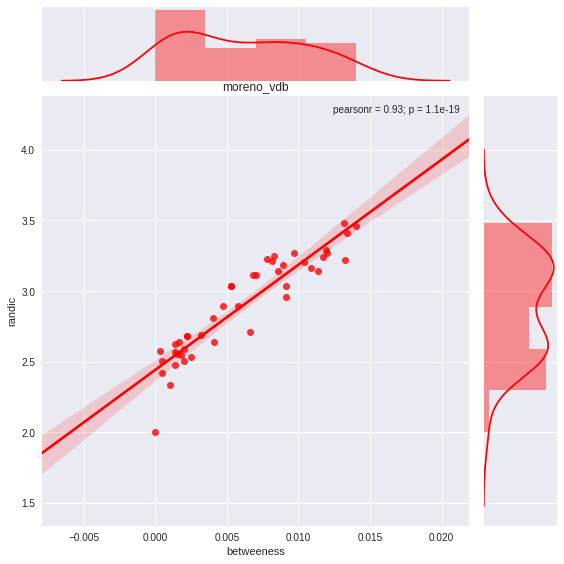

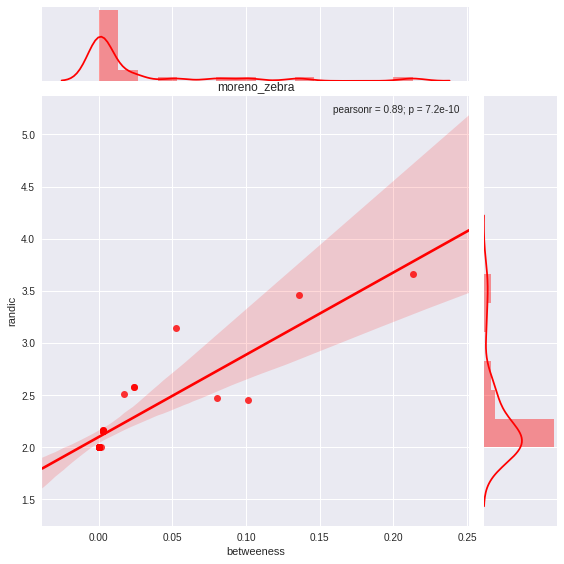

In [325]:
for network_result in results_networks.network.unique():
    sns.jointplot("betweeness", "randic", data=results_networks[results_networks['network']==network_result], kind="reg", color="r", size=8)
    sns.plt.title(network_result)

#### Summary: 
- all (obviously with some variance) networks have high correlations between Randić energy of ego networks and betweeness

### Third experiment: computation time comparison (real-word data)

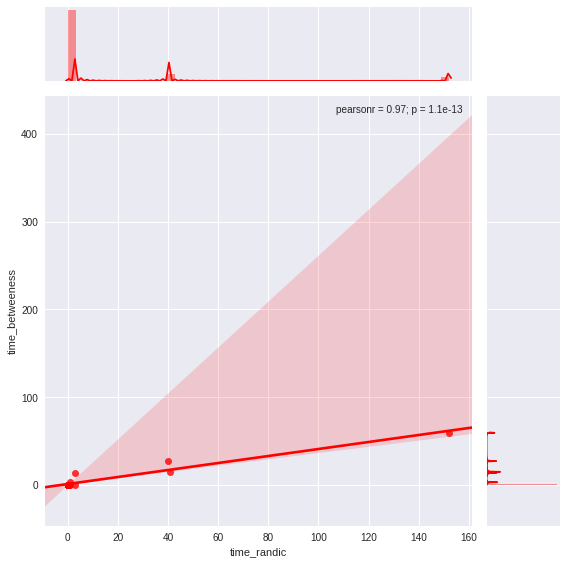

In [327]:
results_networks.groupby(by='network').mean()
sns.jointplot("time_randic", "time_betweeness", data=results_networks.groupby(by='network').mean(), kind="reg", color="r", size=8)

#### Summary: 
- calculation of Randić energy of ego networks takes ~2 time the betweeness take :(
- the need to check the way in which egocentric networks are obtained and the energy is calculated

### Available datasets from KONECT

In [332]:
read_avalilable_datasets_konect()


['actor-collaboration',
 'actor-movie',
 'adjnoun_adjacency',
 'advogato',
 'amazon0601',
 'amazon-ratings',
 'arenas-email',
 'arenas-jazz',
 'arenas-meta',
 'arenas-pgp',
 'as20000102',
 'as-caida20071105',
 'as-skitter',
 'bibsonomy-2ti',
 'bibsonomy-2ui',
 'bibsonomy-2ut',
 'bookcrossing_full-rating',
 'bookcrossing_rating',
 'brunson_club-membership',
 'brunson_southern-women',
 'brunson_corporate-leadership',
 'brunson_revolution',
 'brunson_south-africa',
 'ca-AstroPh',
 'ca-cit-HepPh',
 'ca-cit-HepTh',
 'chess',
 'cfinder-google',
 'citeseer',
 'citeulike-ti',
 'citeulike-ui',
 'citeulike-ut',
 'cit-HepPh',
 'cit-HepTh',
 'com-amazon',
 'com-dblp',
 'com-youtube',
 'contact',
 'contiguous-usa',
 'dblp-author',
 'dblp-cite',
 'dblp_coauthor',
 'dbpedia-all',
 'dbpedia-country',
 'dbpedia-genre',
 'dbpedia-link',
 'dbpedia-location',
 'dbpedia-occupation',
 'dbpedia-producer',
 'dbpedia-recordlabel',
 'dbpedia-starring',
 'dbpedia-team',
 'dbpedia-writer',
 'dbtropes-feature',
 '

### Further experimental scenario:
1. Analitical comparison of computational complexity (Randić ego-nets vs betweeness)
2. Accuracy of betweeness estimation based on Randić ego-nets:
    1. Get real-world networks
    2. Calculate node betweeness
    3. Calculate node Randic energy
    4. Build CV and test with norm-2 error